In [ ]:
import os
import cv2
from glob import glob

In [ ]:
# Set your image directory
IMAGE_DIR = '/content/sample_data/Untitled Folder'
OUT_DIR = '/content/sample_data/pill'
###

all_image_path = glob(os.path.join(IMAGE_DIR, '*.png'))
imageid_path_dict = {(os.path.splitext(os.path.basename(x))[0]): x for x in all_image_path}
for imageid, path in imageid_path_dict.items():
    imageid = str(imageid)
    img = cv2.imread(path)
    w = img.shape[1] // 2
    left_img = img[:, 0: w]
    right_img = img[:, w: img.shape[1]]
    cv2.imwrite(os.path.join(OUT_DIR, imageid + '1.png'), left_img)
  
    print(imageid, "done")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
circle_white-200001126 done
rectangle_pink-202106227 done
circle_blue-200501987 done
circle_white-200800665 done
rectangle_white-201503271 done
circle_red-201404533 done
ellipse_yellowishgreen-200706454 done
ellipse_white-201605774 done
ellipse_white-201207537 done
circle_white-201501727 done
rectangle_brown-201708579 done
circle_white-200810974 done
rectangle_red-200903045 done
rectangle_white-201104024 done
circle_pink-197600550 done
etc_yellow-201502266 done
circle_white-198601878 done
rectangle_yellow-200100769 done
ellipse_white-200805818 done
circle_gray-200800997 done
rectangle_blue-201908237 done
circle_orange-199300354 done
ellipse_yellow-201403085 done
ellipse_orange-201905594 done
rectangle_brown-201804619 done
ellipse_orange-200200478 done
circle_white-200500871 done
etc_white-200500765 done
ellipse_white-201605791 done
circle_pink-201400154 done
etc_white-201403953 done
ellipse_white-201004700 done
circle_white-200201645 done
rectangle_w

In [ ]:
# 패키지 import
import matplotlib
matplotlib.use("Agg")

import os
import cv2
import random
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras_preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# input 이미지의 차원, 채널에 해당하는 축을 설정하여 모델을 초기화
	
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
 
 		# input 이미지의 차원을 알맞게 변경
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

    # CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
  

    # (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  

    # FC => RELU
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# 다중 라벨 분류
		model.add(Dense(classes))
		model.add(Activation(finalAct))
 
 		# 네트워크 아키텍처 반환
		return model


In [ ]:
EPOCHS = 75                 # 모든 학습 데이터셋을 학습하는 횟수
INIT_LR = 1e-3              # 학습률 => 1e-5 부터 시작하여 가장 적합해 보이는 학습률 채택
BS = 32                     # 일반적으로 성능이 뛰어난 32크기의 mini-batch 채택
IMAGE_DIMS = (96, 96, 3)    # 이미지 차원

In [ ]:
# 파일이 실시간으로 읽히고 있는지 확인하기 위해 이미지 갯수 출력
import os
len(os.listdir('/content/sample_data/pill/'))


21384

In [ ]:
# 이미지 경로
imagePaths = "/content/sample_data/pill/"
file_list = os.listdir(imagePaths)

In [ ]:
# 데이터와 라벨을 초기화
data = []
labels = []

# 이미지 전처리
for imagePath in file_list:
  image = cv2.imread('/content/sample_data/pill/'+imagePath)
  # print(image)
  if image is not None : 
    image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # 라벨 리스트 업데이트
    l = label = imagePath.split("-")[0].split("_")
    labels.append(l)

data = np.array(data, dtype= np.float32) / 255.0
labels = np.array(labels)

In [ ]:
# 라벨 이진화 
print("라벨 리스트:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# 리스트에 있는 라벨들을 출력
for (i, label) in enumerate(mlb.classes_):
  print("{}. {}".format(i + 1, label))

라벨 리스트:
1. black
2. black,trans
3. blue
4. blue,light
5. blue,trans
6. bluishgreen
7. bluishgreen,trans
8. brown
9. brown,deep
10. brown,trans
11. circle
12. darkblue
13. darkblue,trans
14. diamond
15. ellipse
16. etc
17. gray
18. green
19. green,trans
20. orange
21. orange,trans
22. pink
23. pink,deep
24. pink,light
25. pink,trans
26. purple
27. purple,trans
28. rectangle
29. red
30. red,trans
31. trans
32. white
33. white,blue
34. white,brown
35. white,green
36. white,orange,trans
37. white,red
38. white,trans
39. white,yellow
40. wine
41. wine,trans
42. yellow
43. yellow,trans
44. yellowishgreen
45. yellowishgreen,trans


In [ ]:
# 학습 데이터와 테스트 데이터를 8:2 비율로 나눔
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# 배열을 1개의 압축되지 않은 npz 포맷 파일로 저장
np.savez('/content/drive/MyDrive/train_data.npz', xtrain = trainX, ytrain = trainY)
np.savez('/content/drive/MyDrive/test_data.npz', xtest = testX, ytest = testY)

In [ ]:
# 이미지 augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# sigmoid 활성화 함수를 네트워크의 마지막 레이어로 설정
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")

# 옵티마이저를 초기화
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

모델 컴파일


In [ ]:
# 네트워크 학습
print("네트워크 학습")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

네트워크 학습


<ipython-input-18-83afcc9b784c>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/75
534/534 [==============================] - 63s 86ms/step - loss: 0.1672 - accuracy: 0.2405 - val_loss: 0.2246 - val_accuracy: 0.2149
Epoch 2/75
534/534 [==============================] - 41s 77ms/step - loss: 0.0574 - accuracy: 0.2607 - val_loss: 0.0793 - val_accuracy: 0.3594
Epoch 3/75
534/534 [==============================] - 41s 77ms/step - loss: 0.0523 - accuracy: 0.2818 - val_loss: 0.0396 - val_accuracy: 0.2455
Epoch 4/75
534/534 [==============================] - 42s 78ms/step - loss: 0.0490 - accuracy: 0.2974 - val_loss: 0.0705 - val_accuracy: 0.3042
Epoch 5/75
534/534 [==============================] - 41s 77ms/step - loss: 0.0454 - accuracy: 0.3138 - val_loss: 0.0411 - val_accuracy: 0.3339
Epoch 6/75
534/534 [==============================] - 46s 87ms/step - loss: 0.0414 - accuracy: 0.3498 - val_loss: 0.0551 - val_accuracy: 0.5901
Epoch 7/75
534/534 [==============================] - 46s 87ms/step - loss: 0.0396 - accuracy: 0.3745 - val_loss: 0.0324 - val_accuracy:

In [ ]:
# 모델 저장
from keras.models import load_model

model.save('/content/drive/MyDrive/pill_model.h5')

# MultiLabelBinarizer  저장
f = open('/content/drive/MyDrive/multilabelbin.txt', "wb")
f.write(pickle.dumps(mlb))
f.close()

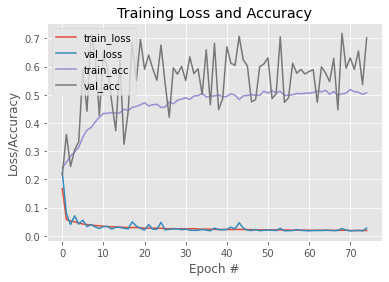

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
# loss와 acc값 plot
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()